In [ ]:
!pip install osmnx 
!pip install -U bokeh==2.2
!pip install -q holoviews
!pip install momepy

!pip install folium==0.12.1 mapclassify

In [ ]:
#if you run into issues with matplotlib, downgrade to this ver:
!pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 7.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.2 requires matplotlib>=3.4, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import osmnx as ox
import geopandas as gpd
import folium
from shapely import wkt
import json

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
gpd.options.use_pygeos = True

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Getting edges where trees are
don't need to run - can just read csv file

In [ ]:
#load imageCoords.csv 
vegData = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/CoordsToEdges/imageCoords.csv')

In [ ]:
#load edges
edges = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/edges.csv')

In [ ]:
from shapely import wkt
edges['geometry'] = edges['geometry'].apply(wkt.loads)

#convert edges to gdf
edges_gdf = gpd.GeoDataFrame(edges, crs='EPSG:4326', geometry=edges['geometry'])

#project geometry
edges_proj = edges_gdf['geometry'].to_crs(3857)
edges_proj

0         LINESTRING (1821202.064 6141639.210, 1821205.2...
1         LINESTRING (1821202.064 6141639.210, 1821207.4...
2         LINESTRING (1821202.064 6141639.210, 1821192.5...
3         LINESTRING (1820725.517 6141334.199, 1820730.2...
4         LINESTRING (1820725.517 6141334.199, 1820721.1...
                                ...                        
150810    LINESTRING (1827710.448 6137762.998, 1827704.9...
150811    LINESTRING (1827710.448 6137762.998, 1827723.7...
150812    LINESTRING (1827710.448 6137762.998, 1827712.8...
150813    LINESTRING (1822289.879 6139617.417, 1822283.8...
150814    LINESTRING (1822289.879 6139617.417, 1822290.6...
Name: geometry, Length: 150815, dtype: geometry

In [ ]:
#find location of trees
tree = ox.geometries_from_bbox(48.2494, 48.1572, 16.2975, 16.4380, tags={"natural": "tree"})
tree_row = ox.geometries_from_bbox(48.2494, 48.1572, 16.2975, 16.4380, tags={"natural": "tree_row"})

In [ ]:
#project tree locations
tree_proj = tree['geometry'].to_crs(3857)
tree_row_proj = tree_row['geometry'].to_crs(3857)

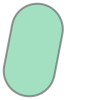

In [ ]:
edges_proj[0].buffer(10)

In [ ]:
type(edges_proj.buffer(10))

geopandas.geoseries.GeoSeries

In [ ]:
edges_proj_buffer = edges_proj.buffer(10)
within = edges_proj.apply(lambda edges_proj: edges_proj_buffer.contains(tree_proj[0]))
within.describe()

In [ ]:
edges_proj.centroid

0         POINT (1821203.634 6141647.328)
1         POINT (1821208.468 6141631.075)
2         POINT (1821187.143 6141642.598)
3         POINT (1820727.877 6141335.309)
4         POINT (1820718.727 6141344.456)
                       ...               
150810    POINT (1827695.021 6137767.517)
150811    POINT (1827791.498 6137722.746)
150812    POINT (1827715.120 6137774.293)
150813    POINT (1822286.856 6139623.061)
150814    POINT (1822295.755 6139602.566)
Length: 150815, dtype: geometry

In [ ]:
#Spatial Index of nodes
from shapely.geometry import Point
from shapely.geometry import LineString

#Convert the graph nodes to shapely points (don't need this part becasue we are finding nearest points to line instead of point to point)

Points_from_lines = gpd.GeoSeries(gpd.points_from_xy(list(edges_proj.centroid.x),list(edges_proj.centroid.y))) 

#create a dictionary that (key:value) = (Point spatialIndex : Node osmid)

edges_uvkey=list(edges.index) #list of edge indicies in osmnx graph
Points_spatialindex=list(Points_from_lines.index)  #list of created points spatial indicies 

osmId_spatialIndex={} 
[osmId_spatialIndex.update({i:j}) for i,j in zip(Points_spatialindex,edges_uvkey)]
len(edges_uvkey)

NameError: ignored

In [ ]:
#convert tree locations to shapely geometry
tree_points = gpd.GeoSeries(gpd.points_from_xy(list(tree_proj.x),list(tree_proj.y)))
tree_points

In [ ]:
#Find nearest points

nearest_points_spatial_index = edges_proj.sindex.nearest(tree_points, return_all=False,return_distance=True) #return_all=False if True, might return more than 1 point if there are equale distance-data structure'll change but more accurate

nearest_edge_index = nearest_points_spatial_index[0][1].tolist()                                                 
distance = nearest_points_spatial_index[1].tolist()  

print(len(distance))

In [ ]:
#cull neareest edge index if trees are further than 20m away
keepIndex = []
for i in range(len(distance)):
  if distance[i] < 20:
    keepIndex.append(i)

nearest_edge_index_2 = []
for i in range(len(keepIndex)):
  nearest_edge_index_2.append(nearest_edge_index[i])

nearest_edge_index_2

In [ ]:
#Relate back to osmid
nearest_graph_edge=[osmId_spatialIndex[i] for i in nearest_edge_index_2]
nearest_graph_edge

In [ ]:
#count number of trees per street
treeCount = [0]*len(edges.index)

for i in range(len(edges.index)):
  count = nearest_graph_edge.count(int(edges.index[i]))
  treeCount[i] = count
  print(i)

#write to csv
# treeCount.to_csv('/content/drive/MyDrive/treeCount.csv')

In [ ]:
treeCount

### Combining Data

In [ ]:
#set up download categories
ox.config(log_console=True, use_cache=True, useful_tags_way = ox.settings.useful_tags_way + ['cycleway'] + ['surface']+['lit'])

# Download the network from bbox
G = ox.graph_from_bbox(48.2494, 48.1572, 16.2975, 16.4380, simplify = True)
nodes, edges = ox.graph_to_gdfs(G)

#drop non relevent edge columns
edges = edges.drop(columns = ['tunnel', 'access', 'ref', 'service', 'width', 'bridge', 'junction', 'area'])

In [ ]:
#read trees count data
treeCount = pd.read_csv('/content/drive/MyDrive/treeCount.csv')

In [ ]:
#add tree counts as column in edges
edges['treeCount'] = list(treeCount['0'])

#set up empty vegPerc column
edges['vegPerc'] = [0]*len(edges)

In [ ]:
#load the mapillary edges and vales
MapillaryVegEdges = pd.read_excel("/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/CoordsToEdges/uvlocs/compileEdgeLocs02.xlsx")
MapillaryVegData = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/CoordsToEdges/imageCoords.csv')

#combine
MapillaryVegEdges['vegPerc'] = MapillaryVegData['vegetation']
MapillaryVegEdges

,uv index,vegPerc
0,"(618683708, 321843468, 0)",0.36
1,"(4688518167, 6486772345, 0)",0.19
2,"(293281946, 293282245, 0)",0.09
3,"(61969017, 7998892838, 0)",0.27
4,"(33471606, 1726420628, 0)",0.15
...,...,...
23694,"(4870192282, 4870192283, 0)",0.56
23695,"(794998845, 794998849, 0)",0.01
23696,"(1183685076, 2693051292, 0)",0.13
23697,"(1557428922, 1557428935, 0)",0.03


In [ ]:
#adding vegPerc values to edge data
for i in range(len(edges.index)):
  try:
    edges.loc[eval(MapillaryVegEdges['uv index'][i]), 'vegPerc'] = MapillaryVegEdges['vegPerc'][i]
  except Exception:
    print('e')
  print(i)

In [ ]:
edges['treeCount'] = treeCount

In [ ]:
unique, counts = np.unique(list(edges['treeCount']), return_counts=True)
print(unique)
print(counts)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54
  55  56  57  60  62  63  64  66  67  68  69  72  77  82  91  93  97 108
 114 171 251]
[134565   5857   2826   1858   1251    867    659    490    384    263
    238    221    182    115    128    114     97     77     54     68
     53     48     43     30     26     32     24     24     22     13
     16     18     20     13      7      8      5     10      9      9
      4      5      5      4      5      1      1      4      1      2
      2      2      2      2      1      1      5      2      2      2
      1      1      1      1      2      1      1      2      1      2
      1      1      1      1      1]


In [ ]:
unique, counts = np.unique(list(edges['vegPerc']), return_counts=True)
print(unique)
print(counts)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.79 0.8  0.81 0.82 0.83 0.85
 0.91 0.93]
[142109    683    477    391    307    276    274    256    261    241
    255    226    227    221    203    226    212    181    204    213
    198    172    155    196    146    159    132    153    170    126
    128    120    137    103    124    121    112     95     93     79
     88     98     76     66     64     54     60     66     63     47
     54     43     34     28     30     23     33     27     22     20
     23     16     15     10     16     10      6     10     13      5
      3      1      3      3      3      1      1      2      2  

### Parks

In [ ]:
#find location of parks
tags = {'leisure': 'park', 'boundary': 'national_park', 'landuse': 'cementary', 'landuse':'recreational_ground'}
parks = ox.geometries_from_bbox(48.2494, 48.1572, 16.2975, 16.4380, tags)

#only inlcude polygons
parks = parks.loc['relation']
parks

In [ ]:
from shapely import wkt
edges['geometry'] = edges['geometry'].apply(wkt.loads)

#convert edges to gdf
edges_gdf = gpd.GeoDataFrame(edges, crs='EPSG:4326', geometry=edges['geometry'])
edges_gdf

In [ ]:
#project geometry
park_proj = parks['geometry'].to_crs(3857)
edges_proj = edges_gdf['geometry'].to_crs(3857)
edges_proj

0         LINESTRING (1821202.064 6141639.210, 1821205.2...
1         LINESTRING (1821202.064 6141639.210, 1821207.4...
2         LINESTRING (1821202.064 6141639.210, 1821192.5...
3         LINESTRING (1820725.517 6141334.199, 1820730.2...
4         LINESTRING (1820725.517 6141334.199, 1820721.1...
                                ...                        
150810    LINESTRING (1827710.448 6137762.998, 1827704.9...
150811    LINESTRING (1827710.448 6137762.998, 1827723.7...
150812    LINESTRING (1827710.448 6137762.998, 1827712.8...
150813    LINESTRING (1822289.879 6139617.417, 1822283.8...
150814    LINESTRING (1822289.879 6139617.417, 1822290.6...
Name: geometry, Length: 150815, dtype: geometry

In [ ]:
park_proj_buffer = park_proj.buffer(30)

In [ ]:
#see which edges are in the park
within = edges_proj.apply(lambda edges_proj: park_proj_buffer.contains(edges_proj))
within.describe()

osmid,178718,180425,1641197,2053076,2426158,2449744,2449745,2449746,2561940,2906770,...,5953090,6522958,6587412,7735480,8497684,12666234,12668102,12833982,12883651,12915821
count,150815,150815,150815,150815,150815,150815,150815,150815,150815,150815,...,150815,150815,150815,150815,150815,150815,150815,150815,150815,150815
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,150773,150763,150792,150657,150481,150786,150797,150781,150747,150736,...,150595,150804,150669,150621,150804,150725,150808,150803,150791,150673


In [ ]:
#check if a street is in any of the parks
inPark = []
for i in range(len(edges.index)):
  inPark.append(True in list(within.iloc[[i]].values[0]))

unique, counts = np.unique(inPark, return_counts=True)
print(unique, counts)

[False  True] [144753   6062]


In [ ]:
#add data to edges info
edges['inPark'] = inPark

### Scoring

In [ ]:
edges = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/edges.csv')

In [ ]:
#remove nan
edges['surface'] = edges['surface'].fillna('no')
edges['lit'] = edges['lit'].fillna('no')

edges['cycleway'] = edges['cycleway'].fillna('no')
edges['highway'] = edges['highway'].fillna('no')

In [ ]:
#assign weights based on highway type
highway = list(edges['highway'])
cycleway = list(edges['cycleway'])
highwayScore = []

for i in range(len(highway)):
  if 'cycleway' in highway[i]:
    if 'segregated' in cycleway[i] or 'separate' in cycleway[i] or 'track' in cycleway[i] or 'sidepath' in cycleway[i]:
      highwayScore.append(0)
    else:
      highwayScore.append(0.1)
  elif 'residential' in highway[i]:
    highwayScore.append(0.25)
  elif 'living_street' in highway[i]:
    highwayScore.append(0.25)
  elif 'service' in highway[i]:
    highwayScore.append(0.5)
  elif 'tertiary' in highway[i]:
    highwayScore.append(0.5)
  elif 'secondary' in highway[i]:
    highwayScore.append(0.75)
  elif highway[i] == 'pedestrian':
    highwayScore.append(1)
  elif highway[i] == 'footway':
    highwayScore.append(1)
  elif highway[i] == 'primary':
    highwayScore.append(1)
  elif highway[i] == 'track':
    highwayScore.append(1)
  elif highway[i] == 'motorway':
    highwayScore.append(1)
  elif highway[i] == 'steps':
    highwayScore.append(1)
  elif highway[i] == 'path':
    highwayScore.append(1)
  else:
    highwayScore.append(1) #this includes unclassified

In [ ]:
#Assign weights based on paving surface
surface = list(edges['surface'])
surfaceScore = []

for i in range(len(surface)):
  if 'concrete' in surface[i]:
    surfaceScore.append(0)
  elif 'asphalt' in surface[i]:
    surfaceScore.append(0)
  else:
    surfaceScore.append(1) #this includes unclassified

In [ ]:
#Assign weights based on street lighting
lit = list(edges['lit'])
litScore = []

for i in range(len(edges.index)):
  if lit[i] == 'yes':
    litScore.append(0)
  else:
    litScore.append(1)

In [ ]:
#Normalize length values
maxLength = max(list(edges['length']))
lengthMod = [(item) / maxLength for item in list(edges['length'])]
edges['lengthMod'] = lengthMod

In [ ]:
#assign weights based on vegetation
tCount = list(edges['treeCount'])
vegP = list(edges['vegPerc'])
iPark = list(edges['inPark'])
vegScore = []

for i in range(len(tCount)):
  if iPark[i] == True:
    vegScore.append(1)
  elif tCount[i] > 25 or vegP[i] > 0.3:
    vegScore.append(0.8)
  elif tCount[i] < 25 and tCount[i] > 15 or vegP[i] < 0.3 and vegP[i] > 0.2:
    vegScore.append(0.6)
  elif tCount[i] < 15 and tCount[i] > 5 or vegP[i] < 0.2 and vegP[i] > 0.1:
    vegScore.append(0.4)
  elif tCount[i] < 5 and tCount[i] > 0.05 or vegP[i] < 0.1 and vegP[i] > 0:
    vegScore.append(0.2)
  else:
    vegScore.append(0)

In [ ]:
#add in scored columns
# edges['lengthMod'] = lengthMod
# edges['litScore'] = litScore
# edges['pavedScore'] = surfaceScore
# edges['safetyScore'] = highwayScore
edges['vegScore'] = vegScore

edges

,Unnamed: 0,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,...,geometry,cycleway,treeCount,vegPerc,lengthMod,litScore,pavedScore,safetyScore,vegScore,inPark
0,0,199732,2447309494,0,29065909,True,3,Universitätsring,secondary,50,...,"LINESTRING (16.36014 48.20866, 16.36016 48.20876)",no,0,0.33,0.008305,0,0,0.75,0.8,False
1,1,199732,4683383695,0,11000070,False,NaN,NaN,cycleway,NaN,...,"LINESTRING (16.36014 48.20866, 16.36019 48.208...",no,2,0.00,0.010832,0,0,0.10,0.2,False
2,2,199732,318697385,0,25535788,False,3,Rathausplatz,tertiary,50,...,"LINESTRING (16.36014 48.20866, 16.36005 48.208...",no,0,0.00,0.015369,0,0,0.50,0.0,False
3,3,199735,8946359241,0,4997667,True,NaN,Schmerlingplatz,tertiary,30,...,"LINESTRING (16.35586 48.20684, 16.35590 48.20685)",no,0,0.00,0.002620,0,0,0.50,0.0,False
4,4,199735,33183691,0,25498425,True,2,Auerspergstraße,secondary,50,...,"LINESTRING (16.35586 48.20684, 16.35582 48.206...",no,0,0.00,0.012364,0,0,0.75,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150810,150810,9785527823,1350779145,0,120473161,False,NaN,Bermenweg,footway,NaN,...,"LINESTRING (16.41860 48.18545, 16.41855 48.185...",no,0,0.00,0.016477,1,0,1.00,0.0,False
150811,150811,9785527823,1350779051,0,120473161,False,NaN,Bermenweg,footway,NaN,...,"LINESTRING (16.41860 48.18545, 16.41872 48.185...",no,0,0.00,0.115639,1,0,1.00,0.0,False
150812,150812,9785527823,1442012761,0,"[130986624, 130986625, 130986627]",False,NaN,NaN,"['footway', 'steps']",NaN,...,"LINESTRING (16.41860 48.18545, 16.41862 48.185...",no,0,0.00,0.012283,0,0,1.00,0.0,False
150813,150813,9785877175,497942122,0,1065575065,False,NaN,NaN,service,NaN,...,"LINESTRING (16.36991 48.19656, 16.36985 48.19662)",no,0,0.00,0.006432,1,1,0.50,0.0,False


In [ ]:
scoredEdges = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/infraredWind/scoredEdgesWind.csv')
scoredEdges

,index,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,...,safetyScore,vegScore,w1,w2,w3,w4,w5,w6,w7,w8
0,"(199732, 2447309494, 0)",199732,2447309494,0,29065909,True,3,Universitätsring,secondary,50,...,0.75,1.0,0.395362,0.375701,0.341093,0.407747,0.369558,0.332137,0.216598,0.373041
1,"(199732, 4683383695, 0)",199732,4683383695,0,11000070,False,NaN,NaN,cycleway,NaN,...,0.10,0.0,0.388995,0.373041,0.332137,0.401154,0.373041,0.349197,0.188607,0.363498
2,"(199732, 318697385, 0)",199732,318697385,0,25535788,False,3,Rathausplatz,tertiary,50,...,0.50,0.0,0.404762,0.363498,0.329900,0.421219,0.379209,0.303158,0.167204,0.385463
3,"(199735, 8946359241, 0)",199735,8946359241,0,4997667,True,NaN,Schmerlingplatz,tertiary,30,...,0.50,0.0,0.313649,0.173554,0.246907,0.349197,0.341093,0.328814,0.282953,0.323298
4,"(199735, 33183691, 0)",199735,33183691,0,25498425,True,2,Auerspergstraße,secondary,50,...,0.75,0.0,0.329900,0.217893,0.163594,0.307174,0.376524,0.328814,0.220779,0.331059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150810,"(9785527823, 1350779145, 0)",9785527823,1350779145,0,120473161,False,NaN,Bermenweg,footway,NaN,...,1.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150811,"(9785527823, 1350779051, 0)",9785527823,1350779051,0,120473161,False,NaN,Bermenweg,footway,NaN,...,1.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150812,"(9785527823, 1442012761, 0)",9785527823,1442012761,0,"[130986624, 130986625, 130986627]",False,NaN,NaN,"['footway', 'steps']",NaN,...,1.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150813,"(9785877175, 497942122, 0)",9785877175,497942122,0,1065575065,False,NaN,NaN,service,NaN,...,0.50,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
scoredEdges['vegScore'] = vegScore

In [ ]:
scoredEdges.to_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/finalScoredEdges.csv')

### Routing

preprocessing

In [ ]:
G = ox.graph_from_bbox(48.2494, 48.1572, 16.2975, 16.4380, simplify = True)
nodes, edges = ox.graph_to_gdfs(G)

In [ ]:
nodes.to_csv('nodes.csv')

final code

In [ ]:
!pip install osmnx 
!pip install geopandas
!pip install networkx
!pip install pygeos

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from shapely.geometry import LineString
import requests
import json
gpd.options.use_pygeos = True

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
scoredEdges = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/finalScoredEdges.csv')

In [ ]:
#convert string to shapely linestring
scoredEdges['geometry'] = scoredEdges['geometry'].apply(wkt.loads)

#convert edges to gdf
scoredEdges_gdf = gpd.GeoDataFrame(scoredEdges, crs='EPSG:4326', geometry=scoredEdges['geometry'])

In [ ]:
#clean edge data and set appropriate index
scoredEdges_gdf = scoredEdges_gdf.drop(columns=['Unnamed: 0', 'index'])
scoredEdges_gdf = scoredEdges_gdf.set_index(['u', 'v', 'key'])
scoredEdges_gdf

osmid  oneway lanes  \
u          v          key                                                    
199732     2447309494 0                             29065909    True     3   
           4683383695 0                             11000070   False   NaN   
           318697385  0                             25535788   False     3   
199735     8946359241 0                              4997667    True   NaN   
           33183691   0                             25498425    True     2   
...                                                      ...     ...   ...   
9785527823 1350779145 0                            120473161   False   NaN   
           1350779051 0                            120473161   False   NaN   
           1442012761 0    [130986624, 130986625, 130986627]   False   NaN   
9785877175 497942122  0                           1065575065   False   NaN   
           497942246  0                             40904413    True   NaN   

                                       name               highway maxspeed  \
u          v          key                                                    
199732     2447309494 0    Universitätsring             secondary       50   
           4683383695 0                 NaN              cycleway      NaN   
           318697385  0        Rathausplatz              tertiary       50   
199735     8946359241 0     Schmerlingplatz              tertiary       30   
           33183691   0     Auerspergstraße             secondary       50   
...                                     ...                   ...      ...   
9785527823 1350779145 0           Bermenweg               footway      NaN   
           1350779051 0           Bermenweg               footway      NaN   
           1442012761 0                 NaN  ['footway', 'steps']      NaN   
9785877175 497942122  0                 NaN               service      NaN   
           497942246  0                 NaN               service      NaN   

                                                surface  lit   length  \
u          v          key                                               
199732     2447309494 0                         asphalt  yes   11.008   
           4683383695 0                         asphalt  yes   14.358   
           318697385  0                         asphalt  yes   20.372   
199735     8946359241 0                         asphalt  yes    3.473   
           33183691   0                         asphalt  yes   16.389   
...                                                 ...  ...      ...   
9785527823 1350779145 0                         asphalt   no   21.841   
           1350779051 0                         asphalt   no  153.281   
           1442012761 0    ['asphalt', 'paving_stones']  yes   16.282   
9785877175 497942122  0                              no   no    8.526   
           497942246  0                              no   no   22.029   

                                                                    geometry  \
u          v          key                                                      
199732     2447309494 0    LINESTRING (16.36014 48.20866, 16.36016 48.20876)   
           4683383695 0    LINESTRING (16.36014 48.20866, 16.36019 48.208...   
           318697385  0    LINESTRING (16.36014 48.20866, 16.36005 48.208...   
199735     8946359241 0    LINESTRING (16.35586 48.20684, 16.35590 48.20685)   
           33183691   0    LINESTRING (16.35586 48.20684, 16.35582 48.206...   
...                                                                      ...   
9785527823 1350779145 0    LINESTRING (16.41860 48.18545, 16.41855 48.185...   
           1350779051 0    LINESTRING (16.41860 48.18545, 16.41872 48.185...   
           1442012761 0    LINESTRING (16.41860 48.18545, 16.41862 48.185...   
9785877175 497942122  0    LINESTRING (16.36991 48.19656, 16.36985 48.19662)   
           497942246  0    LINESTRING (16.36991 48.19656, 16.36992 48.196...   

                           ... saf

In [ ]:
#get windspeed and direction

MY_API_KEY = "4561471e50msh3d1e762ef5340e0p12521djsn5f37f41058cd"

url = "https://community-open-weather-map.p.rapidapi.com/weather"

querystring = {"q":"Vienna, Austria","lat":"0","lon":"0","callback":"","id":"2172797","lang":"null","units":"metric"}

headers = {
	"X-RapidAPI-Host": "community-open-weather-map.p.rapidapi.com",
	"X-RapidAPI-Key": "4561471e50msh3d1e762ef5340e0p12521djsn5f37f41058cd"
}

response = requests.request("GET", url, headers=headers, params=querystring)

#convert response to json
data = json.loads(response.text)

#parse json for relevent data
windDirection = data['wind']['deg']
windSpeed = data['wind']['speed']
print(windDirection, windSpeed)


140 1.54


In [ ]:
#check which wind column direction to use
if windDirection > 337.5 and windDirection < 22.5:
  wCol = 'w1'
elif windDirection > 22.5 and windDirection < 67.5:
  wCol = 'w2'
elif windDirection > 67.5 and windDirection < 112.5:
  wCol = 'w3'
elif windDirection > 112.5 and windDirection < 157.5:
  wCol = 'w4'
elif windDirection > 157.5 and windDirection < 202.5:
  wCol = 'w5'
elif windDirection > 202.5 and windDirection < 247.5:
  wCol = 'w6'
elif windDirection > 247.5 and windDirection < 292.5:
  wCol = 'w7'
else:
  wCol = 'w8'
wCol

#create wind scores
windSpeedList = scoredEdges[wCol]*windSpeed
windScore = []
for i in range(len(windSpeedList)):
  if windSpeedList[i] < 1.8:
    windScore.append(0)
  elif windSpeedList[i] > 1.8 and windSpeedList[i] < 3.6:
    windScore.append(0.25)
  elif windSpeedList[i] > 3.6 and windSpeedList[i] < 5.3:
    windScore.append(0.50)
  elif windSpeedList[i] > 5.3 and windSpeedList[i] < 7.6:
    windScore.append(0.75)
  elif windSpeedList[i] > 7.6:
    windScore.append(1)
  else: 
    windScore.append(0.25)

In [ ]:
scoredEdges_gdf['windScore'] = windScore

In [ ]:
#preferences:  0, 1 to 5,  0: don't include in weight, 1: weight the most, 5: weight the least
bikePref = 5
litPref = 0
surfacePref = 5
vegPref = 0
windPref = 0
lengthPref = 5

#create windScore
np.array(windPref*scoredEdges[wCol]*windSpeed)

combinedScore = np.array(bikePref*scoredEdges['safetyScore']) + np.array(litPref*scoredEdges['litScore']) + np.array(surfacePref*scoredEdges['pavedScore']) + np.array(lengthPref*scoredEdges['lengthMod']) + np.array(vegPref*scoredEdges['vegScore'] + np.array(windPref*scoredEdges_gdf['windScore']))
scoredEdges_gdf['combinedScore'] = combinedScore

In [ ]:
nodes_df = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/nodes.csv')

In [ ]:
nodes_df

,osmid,y,x,highway,street_count,ref,geometry
0,199732,48.208662,16.360136,traffic_signals,4,NaN,POINT (16.3601365 48.2086619)
1,199735,48.206836,16.355856,traffic_signals,4,NaN,POINT (16.3558556 48.2068359)
2,199736,48.207697,16.355375,NaN,3,NaN,POINT (16.3553748 48.2076973)
3,199739,48.214093,16.359259,NaN,3,NaN,POINT (16.3592592 48.2140926)
4,199740,48.214422,16.358265,NaN,4,NaN,POINT (16.3582651 48.214422)
...,...,...,...,...,...,...,...
56629,9792195680,48.244985,16.368995,NaN,3,NaN,POINT (16.3689951 48.2449851)
56630,9793858702,48.197753,16.305677,NaN,3,NaN,POINT (16.3056768 48.1977534)
56631,9793858703,48.198452,16.306842,NaN,3,NaN,POINT (16.306842 48.1984517)
56632,9793858704,48.198686,16.307022,NaN,3,NaN,POINT (16.3070219 48.1986864)


In [ ]:
#convert node csv to df to gdf
node_df = pd.DataFrame(
    {'y': list(nodes_df['y']),
     'x': list(nodes_df['x'])})

node_gdf = gpd.GeoDataFrame(node_df, geometry=gpd.points_from_xy(node_df.x, node_df.y))
node_gdf['osmid'] = list(nodes_df['osmid'])
node_gdf = node_gdf.set_index('osmid')
node_gdf

,y,x,geometry
osmid,,,
199732,48.208662,16.360136,POINT (16.36014 48.20866)
199735,48.206836,16.355856,POINT (16.35586 48.20684)
199736,48.207697,16.355375,POINT (16.35537 48.20770)
199739,48.214093,16.359259,POINT (16.35926 48.21409)
199740,48.214422,16.358265,POINT (16.35827 48.21442)
...,...,...,...
9792195680,48.244985,16.368995,POINT (16.36900 48.24499)
9793858702,48.197753,16.305677,POINT (16.30568 48.19775)
9793858703,48.198452,16.306842,POINT (16.30684 48.19845)


In [ ]:
scoredEdges_gdf

In [ ]:
G_weighted = ox.graph_from_gdfs(node_gdf, scoredEdges_gdf)

In [ ]:
#Find node closest to start and end points (NEED TO REWRITE THIS USING SINDEX NEAREST)
# Source
source_address = "Schönbrunn Palace, Austria"
source_location= ox.geocode(source_address)  # notice the coordinate order (y, x)
source_point = Point(source_location[1], source_location[0])

# Target
target_address = "Laufbergergasse 12, 1020 Wien, Austria"
target_location = ox.geocode(target_address) 
target_point = Point(target_location[1], target_location[0])

#Get index of nearest nodes in the graph for the source and target locations
source_index = node_gdf.sindex.nearest(source_point, return_all=False)
target_index = node_gdf.sindex.nearest(target_point, return_all=False)

#get osmid of nearest node
source_node = list(node_gdf.iloc[[source_index[1][0]]].index)[0]
target_node = list(node_gdf.iloc[[target_index[1][0]]].index)[0]

In [ ]:
#shortest route
route = ox.distance.shortest_path(G_weighted, source_node, target_node, weight = 'combinedScore')

In [ ]:
#route node osmid to geometry to json
lat_list = list(node_gdf.loc[route].x)
long_list = list(node_gdf.loc[route].y)

route_geom = LineString(zip(lat_list, long_list))
route_json = gpd.GeoSeries([route_geom]).to_file('route_json.geojson', driver='GeoJSON')

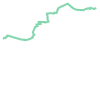

In [ ]:
route_geom

In [ ]:
#print route characteristics
routeType = route

lengthBike = 0
lengthPaved = 0
lengthLit = 0
length = 0
lengthVeg = 0
lengthWindCalm = 0

for i in range(len(routeType)-1):
  length += G_weighted[routeType[i]][routeType[i+1]][0]['length']
  if G_weighted[routeType[i]][routeType[i+1]][0]['highway'] == 'cycleway':
    lengthBike += G_weighted[routeType[i]][routeType[i+1]][0]['length']
  if G_weighted[routeType[i]][routeType[i+1]][0]['surface'] == 'concrete' or G_weighted[routeType[i]][routeType[i+1]][0]['surface'] == 'asphalt':
    lengthPaved += G_weighted[routeType[i]][routeType[i+1]][0]['length']
  if G_weighted[routeType[i]][routeType[i+1]][0]['lit'] == 'yes':
    lengthLit += G_weighted[routeType[i]][routeType[i+1]][0]['length']
  if G_weighted[routeType[i]][routeType[i+1]][0]['vegScore'] > 0.5:
    lengthVeg += G_weighted[routeType[i]][routeType[i+1]][0]['length']
  if G_weighted[routeType[i]][routeType[i+1]][0]['windScore'] < 0.50:
    lengthWindCalm += G_weighted[routeType[i]][routeType[i+1]][0]['length']

print('% Lit: ' + str(round((lengthLit*100/length), 2)) + 
      '\n% Paved: '+ str(round((lengthPaved*100/length), 2)) + 
      '\n% Bike Lane: '+ str(round((lengthBike*100/length), 2)) + 
      '\n% of route with moderate to high amounts of veg: '+ str(round((lengthVeg*100/length), 2)) +
      '\n% Calm Wind: '+ str(round((lengthWindCalm*100/length), 2)) + 
      '\nTotal Length: '+ str(round((length), 2)))


% Lit: 94.88
% Paved: 87.44
% Bike Lane: 58.25
% of route with moderate to high amounts of veg: 31.24
% Calm Wind: 100.0
Total Length: 11005.61


In [ ]:
# View weighted route
wRoute = []

for i in range(len(route)):
  wRoute.append((nodes.loc[route[i]].y, nodes.loc[route[i]].x))

w = scoredEdges_gdf.explore(
    column ="combinedScore",
    tooltip_kwds=dict(labels=True),
    popup="combinedScore",
    k=10,
    name="combinedScore",
)

folium.PolyLine(wRoute, color='red',dash_array='10').add_to(w)
folium.TileLayer('cartodbpositron', control=True).add_to(w)
w

# Interactive Wind

In [ ]:
scoredEdges = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/finalScoredEdges.csv')

In [ ]:
#get windspeed and direction

MY_API_KEY = "4561471e50msh3d1e762ef5340e0p12521djsn5f37f41058cd"

url = "https://community-open-weather-map.p.rapidapi.com/weather"

querystring = {"q":"Vienna, Austria","lat":"0","lon":"0","callback":"","id":"2172797","lang":"null","units":"metric"}

headers = {
	"X-RapidAPI-Host": "community-open-weather-map.p.rapidapi.com",
	"X-RapidAPI-Key": "4561471e50msh3d1e762ef5340e0p12521djsn5f37f41058cd"
}

response = requests.request("GET", url, headers=headers, params=querystring)

#convert response to json
data = json.loads(response.text)

#parse json for relevent data
windDirection = data['wind']['deg']
windSpeed = data['wind']['speed']
print(windDirection, windSpeed)


100 1.54


In [ ]:
#check which wind column direction to use
if windDirection > 337.5 and windDirection < 22.5:
  wCol = 'w1'
elif windDirection > 22.5 and windDirection < 67.5:
  wCol = 'w2'
elif windDirection > 67.5 and windDirection < 112.5:
  wCol = 'w3'
elif windDirection > 112.5 and windDirection < 157.5:
  wCol = 'w4'
elif windDirection > 157.5 and windDirection < 202.5:
  wCol = 'w5'
elif windDirection > 202.5 and windDirection < 247.5:
  wCol = 'w6'
elif windDirection > 247.5 and windDirection < 292.5:
  wCol = 'w7'
else:
  wCol = 'w8'
wCol

'w3'

In [ ]:
windEdges = scoredEdges[['geometry', wCol]]
windSpeed_list = windEdges[wCol]*windSpeed

#assign colors
wColor = []
for i in range(len(windSpeed_list)):
  if windSpeed_list[i] < 0.5:
    wColor.append('FFFFF')
  elif windSpeed_list[i] > 0.5 and windSpeed_list[i] <= 1.0 :
    wColor.append('CFF8FF')
  elif windSpeed_list[i] > 1 and windSpeed_list[i] <= 2 :
    wColor.append('37DFFF')
  elif windSpeed_list[i] > 2 and windSpeed_list[i] <= 3:
    wColor.append('22B4CE')
  elif windSpeed_list[i] > 3 and windSpeed_list[i] <= 4:
    wColor.append('027C93')
  elif windSpeed_list[i] > 4 and windSpeed_list[i] <= 5 :
    wColor.append('0C505E')
  else : 
    wColor.append('03323E')


windEdges[wCol] = windSpeed_list
windEdges['color'] = wColor
windEdges

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,geometry,w3,color
0,"LINESTRING (16.3601365 48.2086619, 16.3601647 ...",0.525283,CFF8FF
1,"LINESTRING (16.3601365 48.2086619, 16.3601852 ...",0.511491,CFF8FF
2,"LINESTRING (16.3601365 48.2086619, 16.3600511 ...",0.508046,CFF8FF
3,"LINESTRING (16.3558556 48.2068359, 16.355898 4...",0.380237,FFFFF
4,"LINESTRING (16.3558556 48.2068359, 16.3558166 ...",0.251935,FFFFF
...,...,...,...
150810,"LINESTRING (16.4186023 48.1854515, 16.4185531 ...",NaN,03323E
150811,"LINESTRING (16.4186023 48.1854515, 16.4187221 ...",NaN,03323E
150812,"LINESTRING (16.4186023 48.1854515, 16.418624 4...",NaN,03323E
150813,"LINESTRING (16.3699085 48.1965569, 16.3698542 ...",NaN,03323E


In [ ]:
#convert string to shapely linestring
windEdges['geometry'] = windEdges['geometry'].apply(wkt.loads)

#convert edges to gdf
windEdges_gdf = gpd.GeoDataFrame(windEdges, crs='EPSG:4326', geometry=windEdges['geometry'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
windEdges_gdf.to_file('windEdges.geojson', driver='GeoJSON')  

# pip freeze

In [ ]:
!pip freeze --local > /content/colab_installed.txt

In [ ]:
!pip freeze > requirements.txt

In [ ]:
f = open('requirements.txt')
print(f.read())

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2022.5.18.1
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==1.3.0
cmake==3.22.4
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
desca

In [ ]:
!pip install pipreqs
!pip install nbconvert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nbconvert --output-dir="./reqs" --to script my\ nb.ipynb

SyntaxError: ignored

In [ ]:
import sys
print(sys.modules.keys())

dict_keys(['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'warnings', 're', 'enum', 'types', '_collections', 'sre_compile', '_sre', 'sre_parse', 'sre_constants', 'functools', '_functools', 'collections', '_collections_abc', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', 'copyreg', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_sitebuiltins', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'google', 'google.cloud', 'google.logging', 'mpl_toolkits', 'sphinxcontrib', 'sitecustomize', 'runpy', 'pkgutil', 'weakref', '_weakrefset', 'ipykernel', 'ipykernel._version', 'ipykernel

In [ ]:
import session_info
session_info.show()